# TFG "Entrenamiento de Redes Convolucionales mediante la Transformada de Fourier"
* Autora: Isabel María Moreno Cuadrado

# Comparación de métodos de convolución.

A continuación se realiza una comparación de varios métodos de convolución utilizando diferentes librerías y enfoques (NumPy, SciPy, OpenCV, FFT con NumPy y FFT con TensorFlow) sobre datos sintéticos de distintos tamaños. El resultado obtenido usando cada algoritmo es el mismo y el objetivo reside en medir y comparar el tiempo de ejecución de cada método para diferentes configuraciones.

Los métodos que se van a comparar son los siguientes, algunos de los cuales son ampliamente utilizados en VC, especialmente la versión de OpenCV por su implementación altamente optimizada.

- **Convolución usando NumPy:** Realiza la convolución utilizando bucles `for` y operaciones de suma y multiplicación. Es una implementación siguiendo el algoritmo a fuerza bruta usando la librería Numpy.
- **Convolución usando SciPy:** Utiliza la función `convolve2d` de SciPy para realizar la convolución. Es una implementación más optimizada que la anterior.
- **Convolución usando OpenCV:** Utiliza la función `filter2D` de OpenCV para realizar la convolución. Es una de las implementaciones más rápidas ya que usa programación de bajo nivel, y está altamente optimizada. Usa la GPU para mejorar el rendimiento.
- **Convolución usando el Algoritmo `convolucion_fft`:** Función propia que utiliza la FFT para realizar la convolución en el dominio de la frecuencia.
- **Convolución usando el Algoritmo `convolucion_fft` ejecutado sobre GPU:** Similar al método anterior, pero utilizando TensorFlow para aprovechar las optimizaciones y la GPU.

En detalle, se presenta el tiempo de ejecución de cada método para distintos valores de tamaño del kernel: 3, 5, 7, 9, 11, 16, 20 y 24. Estos valores se analizan en el contexto de diferentes tamaños de imágenes, específicamente 128, 256, 512, 1024, 2048, 3000, 4000 y 5000 píxeles. Para cada combinación de tamaño del kernel y tamaño de la imagen, se mide y se muestra el tiempo que cada método tarda en ejecutarse.

Nota: La convolución que se compara es la de modo "same" y stride 1.


In [ ]:
import numpy as np
import scipy.signal
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import time
import signal


class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

signal.signal(signal.SIGALRM, timeout_handler)

def convolution_numpy(image, kernel, timeout=30):
    signal.alarm(timeout)
    try:
        start_time = time.time()
        result = np.zeros_like(image)
        image_padded = np.pad(image, ((kernel.shape[0] // 2, kernel.shape[0] // 2),
                                      (kernel.shape[1] // 2, kernel.shape[1] // 2)), mode='constant')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                result[i, j] = np.sum(image_padded[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
        elapsed_time = time.time() - start_time
        signal.alarm(0)
        return result, elapsed_time
    except TimeoutException:
        return None, "Timeout"

def convolution_scipy(image, kernel, timeout=30):
    signal.alarm(timeout)
    try:
        start_time = time.time()
        result = scipy.signal.convolve2d(image, kernel, mode='same')
        elapsed_time = time.time() - start_time
        signal.alarm(0)
        return result, elapsed_time
    except TimeoutException:
        return None, "Timeout"

def convolution_opencv(image, kernel, timeout=30):
    signal.alarm(timeout)
    try:
        start_time = time.time()
        result = cv2.filter2D(image, -1, kernel)
        elapsed_time = time.time() - start_time
        signal.alarm(0)
        return result, elapsed_time
    except TimeoutException:
        return None, "Timeout"


# Función de convolución usando FFT en modo 'same'
def convolution_fft(image, kernel):
    H, W = image.shape
    kH, kW = kernel.shape

    # Calcular el tamaño de la FFT añadiendo el padding necesario
    fftsize = (2**int(np.ceil(np.log2(H + kH - 1))), 2**int(np.ceil(np.log2(W + kW - 1))))

    # Añadir padding a la imagen
    padded_image = np.pad(image, ((0, kH - 1), (0, kW - 1)), mode='constant')

    # Realizar la FFT de la imagen y el kernel
    image_fft = np.fft.fft2(padded_image, fftsize)
    kernel_fft = np.fft.fft2(kernel, fftsize)

    # Multiplicar las FFTs
    result_fft = image_fft * kernel_fft

    # Inversa de la FFT para obtener el resultado convolucionado
    result_inversa = np.fft.ifft2(result_fft)

    # Tomar la parte real del resultado
    result_inversa = np.real(result_inversa)

    # Recortar para obtener el tamaño original de la imagen
    result_central = result_inversa[kH // 2: kH // 2 + H, kW // 2: kW // 2 + W]

    return result_central


def convolution_fft_gpu(image, kernel, timeout=30):
    signal.alarm(timeout)
    try:
        H, W = image.shape
        hs = kernel.shape[0] // 2
        fftsize = 2**int(np.ceil(np.log2(max(H, W) + hs)))

        start_time = time.time()
        kernel_shape = tf.shape(kernel)
        padded_kernel = tf.pad(kernel, [(0, fftsize - kernel_shape[0]), (0, fftsize - kernel_shape[1])])
        kernel_fft = tf.signal.fft2d(tf.cast(padded_kernel, tf.complex64))

        image_shape = tf.shape(image)
        padded_image = tf.pad(image, [(0, fftsize - image_shape[0]), (0, fftsize - image_shape[1])])
        image_fft = tf.signal.fft2d(tf.cast(padded_image, tf.complex64))

        result_fft = image_fft * kernel_fft
        result_inversa = tf.signal.ifft2d(result_fft)
        result_inversa = result_inversa[hs:hs+H, hs:hs+W]
        elapsed_time = time.time() - start_time
        signal.alarm(0)
        return tf.math.real(result_inversa).numpy(), elapsed_time
    except TimeoutException:
        return None, "Timeout"

                  Método  Tamaño de Imagen  Tamaño de Núcleo     Tiempo
0                  Numpy               128                 3   0.408147
1                  Scipy               128                 3   0.001267
2                 OpenCV               128                 3   0.032823
3        convolucion_fft               128                 3   0.031018
4    convolucion_fft_gpu               128                 3   2.395056
..                   ...               ...               ...        ...
315                Numpy              5000                24    Timeout
316                Scipy              5000                24    Timeout
317               OpenCV              5000                24   0.378381
318      convolucion_fft              5000                24  11.362277
319  convolucion_fft_gpu              5000                24   0.233176

[320 rows x 4 columns]


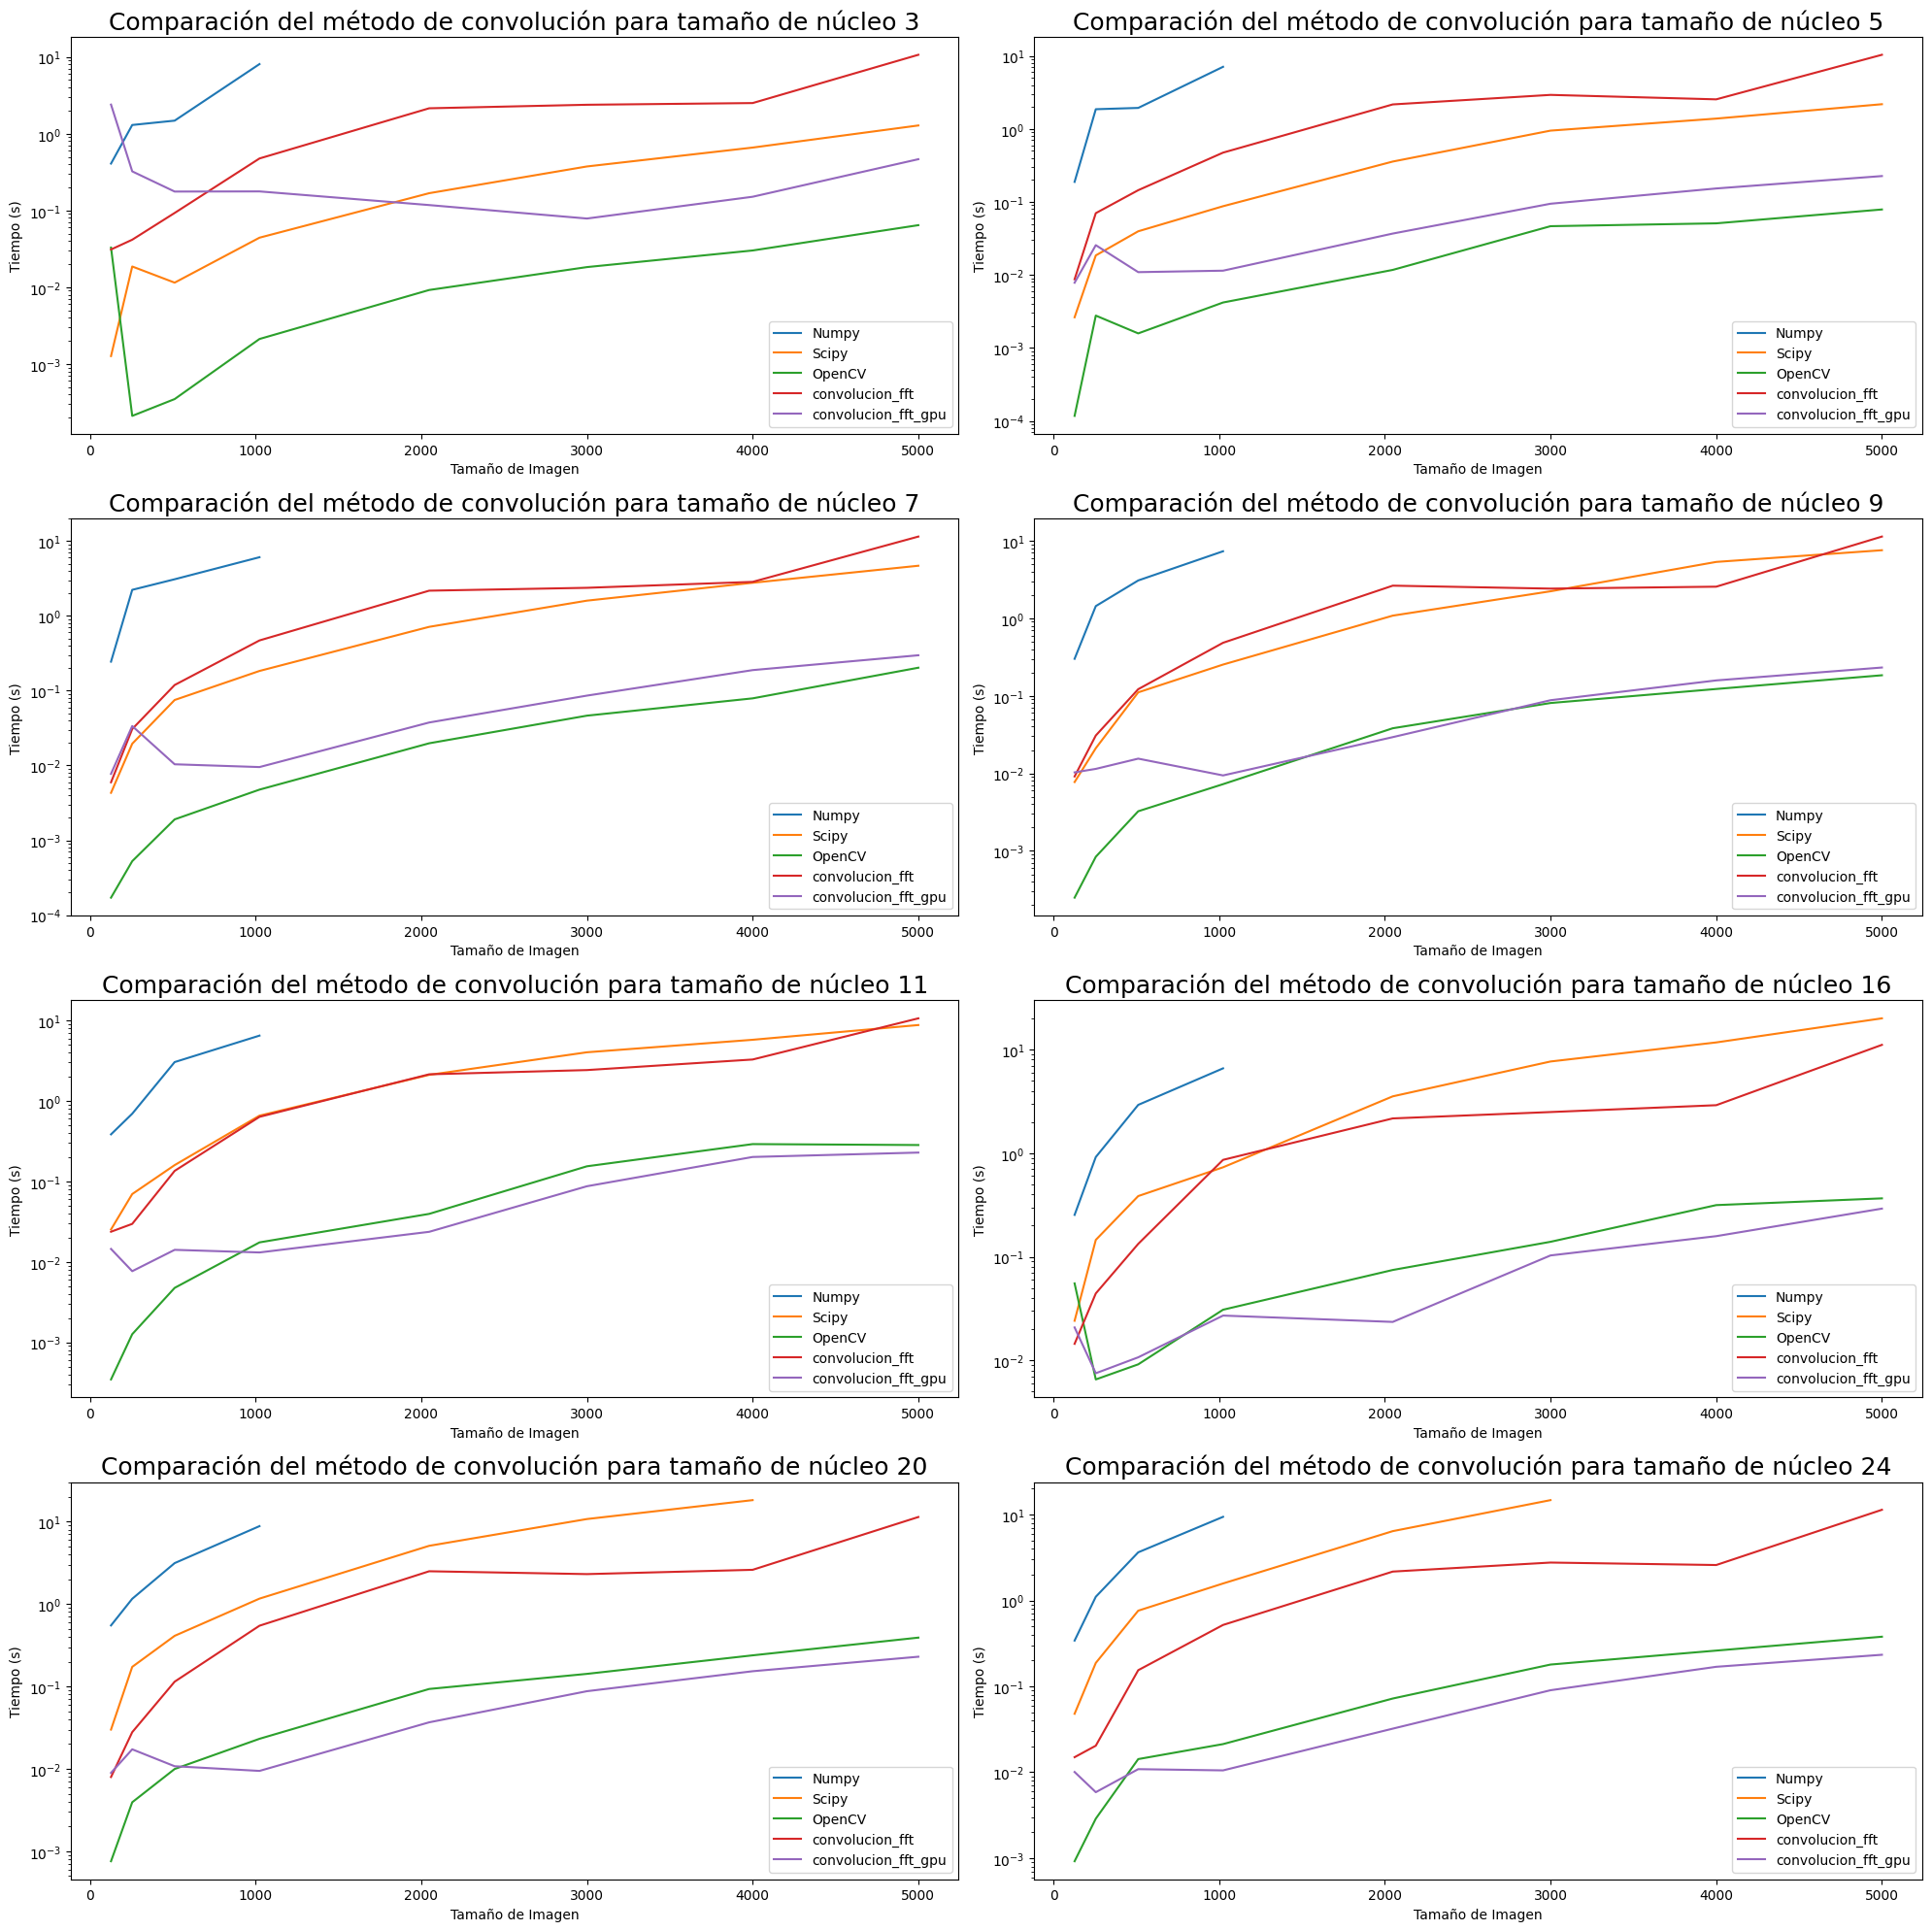

In [ ]:
# Generación de datos sintéticos
image_sizes = [128, 256, 512, 1024, 2048, 3000, 4000, 5000]
kernel_sizes = [3, 5, 7, 9, 11, 16, 20, 24]

methods = {
    'Numpy': convolution_numpy,
    'Scipy': convolution_scipy,
    'OpenCV': convolution_opencv,
    'convolucion_fft': convolution_fft,
    'convolucion_fft_gpu': convolution_fft_gpu
}

results = []
timeout_seconds = 25  # tiempo máximo permitido para cada método sino se realiza un TimeOut

for size in image_sizes:
    image = np.random.rand(size, size).astype(np.float32)
    for k_size in kernel_sizes:
        kernel = np.random.rand(k_size, k_size).astype(np.float32)
        for name, method in methods.items():
            result, elapsed_time = method(image, kernel, timeout=timeout_seconds)
            results.append({'Método': name, 'Tamaño de Imagen': size, 'Tamaño de Núcleo': k_size, 'Tiempo': elapsed_time})

# Crear DataFrame y guardar en un archivo CSV
df = pd.DataFrame(results)
df.to_csv('comparison_results.csv', index=False)

# Mostrar la tabla completa
print(df)

# Filtrar resultados que no sean 'Timeout' y convertir a float
df = df[df['Tiempo'] != "Timeout"]
df['Tiempo'] = df['Tiempo'].astype(float)

# Graficar los resultados para diferentes tamaños de núcleo en un formato de mosaico
fig, axes = plt.subplots(len(kernel_sizes) // 2, 2, figsize=(20, 20))
axes = axes.flatten()

for i, k_size in enumerate(kernel_sizes):
    subset = df[df['Tamaño de Núcleo'] == k_size]
    for method in methods.keys():
        method_subset = subset[subset['Método'] == method]
        axes[i].plot(method_subset['Tamaño de Imagen'], method_subset['Tiempo'], label=method)
    axes[i].set_xlabel('Tamaño de Imagen')
    axes[i].set_ylabel('Tiempo (s)')
    axes[i].set_yscale('log')
    axes[i].set_title(f'Comparación del método de convolución para tamaño de núcleo {k_size}', fontsize=18)
    axes[i].legend()

plt.tight_layout()
plt.show()


# RESULTADOS

Los resultados se pueden visualizar en la imagen anterior.
Analizando estos, es evidente que el método implementado mediante Numpy muestra una falta de eficiencia incluso para tamaños de kernel e imagen relativamente pequeños.

En general, el método que hemos propuesto y que está implementado para aprovechar la capacidad de la GPU muestra una superioridad notable sobre la mayoría de los algoritmos convencionales, con la excepción notable del algoritmo utilizado en OpenCV. Específicamente, para kernels de tamaño más pequeño, OpenCV tiende a ofrecer tiempos de procesamiento más reducidos en comparación con nuestro método propuesto.

No obstante, a medida que incrementamos las dimensiones del kernel, la disparidad en el rendimiento se hace más notable. En particular, cuando se utiliza un kernel de tamaño 9, ya empezamos a observar una mejora significativa en los tiempos de procesamiento con el método que hemos propuesto para la GPU. Esta tendencia se acentúa aún más con un kernel de tamaño 11, donde nuestro método comienza a demostrar una superioridad clara en términos de eficiencia.

Este fenómeno es particularmente interesante considerando que nuestra implementación, a pesar de estar diseñada para aprovechar la aceleración por GPU, no está completamente optimizada ni emplea técnicas de programación paralela en su totalidad. Esto constata que incluso una implementación no completamente refinada del método propuesto supera a las técnicas usadas comunmente en el AA. Este análisis coincide con el que se ha realizado de manera teórica.